# IFS-TC Forensics Challenge

## [1.0] Business Problem
- The IEEE Information Forensics Security Technical Committee (IFS-TC) launched a detection and localization forensics challenge, the first Image Forensics Challenge.
- In the last years, the field of Digital Image Forensics has emerged with several tools and algorithms presented to help researchers and forensic experts to interpret the authenticity of digital documents.
- However, the lack of a clear benchmark and common comparison protocol of such algorithms has limited us to gauge them under real-world conditions

## [1.1] Problem Statement
- Given an input image our task is to predict the modified part in an image, or to identify forgeries in digital images.
- To evaluate the current state-of-the-art techniques with respect to their ability to detect image forgeries (content manipulation)
- This is the task of identifying content manipulation

## [1.2] References
- https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
- https://www.immersivelimit.com/tutorials/mask-rcnn-for-windows-10-tensorflow-2-cuda-101
- https://www.pyimagesearch.com/2019/06/10/keras-mask-r-cnn/
- https://www.kaggle.com/c/tgs-salt-identification-challenge
- http://web.archive.org/web/20171014064017/http://ifc.recod.ic.unicamp.br/fc.website/index.py?sec=1
- https://www.jeremyjordan.me/semantic-segmentation/
- https://arxiv.org/pdf/1505.04597.pdf
- https://github.com/MrGiovanni/UNetPlusPlus

## [1.3] Data Overview
- We have folder of fake images of total 900 digital images out of which 450 are digital images and rest 450 are their corresponding masks.
- In an input image we have to identify the modified part for these 450 images

## [1.4] Performance Metric
- Jaccard Similarity: It is one of the performance metric which we will be using. It is also known as Intersection over Union (IoU).
 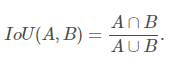
- Here A is our ground truth and B is our model predicted output.
- We compute this value at each pixel and then take an average precision.
- For that we keep a thresholding values which ranges from 0.5 - 0.95. It is a hyperparameter to tune.
- At each threshold value t, a precision value is calculated based on the number of TP(true positives), false negatives(FN) and false positives(FP) resulting from comparing the predicted object to all ground truth objects.
- A TP is counted when a single predicted object matches a ground truth object with IoU above the threshold.
- A FP indicates a predicted object has no associated ground truth.
- A FN indicates a ground truth object has no associated preicted object.
- The average precision of a single image is then calculated as the mean of the above precision values at each IoU threshold

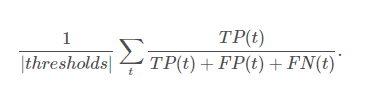

## [1.5] Importing all the important libraries

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Add
from tensorflow.keras.losses import binary_crossentropy
from tensorflow import concat 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator

In [2]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-va56y41v
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-va56y41v
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33791 sha256=865e80a94b0e73f2bdfb43be87af55533eeef030c4d2fe12cd5372790fb53325
  Stored in directory: /tmp/pip-ephem-wheel-cache-wo5yv2xq/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [1]:
!pip install q keras==2.3.1

In [3]:
input_shape = (256,256,3)
backbone = EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
input_ = backbone.input

In [4]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [5]:
from google.colab import drive

In [6]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
!ls "/content/gdrive/My Drive"

'Asif Khan Resume Word File (1).docx'
'Asif Khan Resume Word File.docx'
 asiflaik@gmail.com_CS1.gdoc
 Assignments_AFR_2018
 bank.gsheet
 Classroom
'Colab Notebooks'
'Copy of asiflaik@gmail.com_CS1.gdoc'
 Db-IMDB.db
'DeepLearning Interview Questions & Answers.gdoc'
 fake
'How to get started with Drive.pdf'
'IEEE Fraud Detection.ipynb'
 l.png
 Masira.zip
'Model U-Net ++'
 Photo.jpg
'SAS rough notes.docx'
 sharable_image.png
 sql_question.gdoc
 Titanic


In [8]:
import os
os.getcwd()

'/content'

In [9]:
directory = '/content/gdrive/My Drive/fake/lis1'
for i in os.listdir(directory):
    print(i)
    break

b59eb013150b52fdac02f8a50ff9ca47.mask.png


## [2.0] Reading image ids and mask ids

In [10]:
ids_mask = next(os.walk('/content/gdrive/My Drive/fake/lis1'))[2]
print('Ids of mask: ',len(ids_mask))
ids_only = next(os.walk('/content/gdrive/My Drive/fake/lis1'))[2]
print('Ids only: ',len(ids_only))

Ids of mask:  450
Ids only:  450


In [11]:
im_height = 256
im_width = 256
channels = 3
X = np.zeros((len(ids_only), im_height, im_width, channels), dtype=np.float32)
y = np.zeros((len(ids_mask), im_height, im_width, channels), dtype=np.float32)

## [2.1] Preprocessing Image features

In [12]:
import tqdm
directory = '/content/gdrive/My Drive/fake/lis2'
for n,i in tqdm.tqdm_notebook(enumerate(os.listdir(directory))):
    img = load_img(directory + '/' + i)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_height, im_width, channels), mode = 'constant', preserve_range = True)
    X[n] = x_img/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


## [2.2] Preprocessing Mask images

In [13]:
import tqdm
directory = '/content/gdrive/My Drive/fake/lis1'
for n,i in tqdm.tqdm_notebook(enumerate(os.listdir(directory))):
    #img = load_img(directory + '/' + i)
    mask = img_to_array(load_img(directory+'/' +i))
    mask = resize(mask, (im_height, im_width, channels), mode = 'constant', preserve_range = True)
    # Save images
    y[n] = np.where(mask > 127,1,0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## [3.0] Splitting data into train and val

In [14]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=42)

## [4.0] Building a model

In [15]:
tf.keras.backend.clear_session()

In [16]:
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            print(type(true))
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric

def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_function(get_iou_vector, [label, pred > 0.5], tf.float32)

In [17]:
metric = 0.0
type(metric)

float

In [18]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [19]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    print(type(blockInput))
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [20]:
def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    input_ = backbone.input
    start_neurons = 8
    print('Input',input_)

    conv4 = backbone.layers[323].output
    print('Conv4',conv4)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)   
    
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    #1st concat
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 

    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[146].output
    #2nd concat
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[87].output

    #3rd concat
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
   # print('uconv2',uconv2)
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[28].output
    #4th concat
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    #uconv1 = concatenate([uconv1,deconv4_up4])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
#     uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(3, (1,1), padding="same", activation="sigmoid")(uconv0)    
    print('Output Layer',output_layer)
    
    model = Model(input_, output_layer)
   # model.name = 'u-xception'

    return model

In [21]:
img_size = 256
model = UEfficientNet(input_shape=(img_size,img_size,3),dropout_rate=0.5)

Input Tensor("input_1:0", shape=(None, 256, 256, 3), dtype=float32)
Conv4 Tensor("block5f_add/add:0", shape=(None, 16, 16, 160), dtype=float32)
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
deconv1:, Tensor("conv2d_transpose_9/BiasAdd:0", shape=(None, 128, 128, 16), dtype=float32)
deconv2:, Tensor("conv2d_transpose_7/BiasAdd:0", shape=(None, 64, 64, 32), dtype=float32)
deconv3:, Tensor("conv2d_transpose_4/BiasAdd:0", shape=(None, 32, 32, 64), dtype=float32)
deconv4:, Tensor("conv2d_transpose/BiasAdd:0", shape=(None, 16, 16, 128), dtype=float32)
deconv2_up1:, Tensor("conv2d_transpose_8/BiasAdd:0", shape=(None, 128, 128, 32), dtype=float32)
deconv3_up1:, Tensor("conv2d_transpose_5/BiasAdd:0", shape=(None, 64, 64, 64), dtype=float32)
deconv3_up2:, Tensor("conv2d_transpose_6/BiasAdd:0", shape=(

In [22]:
#from tensorflow.keras.metrics import MeanIoU

In [23]:
from segmentation_models.metrics import IOUScore
metric = IOUScore()
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[metric])

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


In [24]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [25]:
filepath = '/content/gdrive/My Drive/Model U-Net ++/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min') 

h=model.fit(X_train,y_train,batch_size = 16, epochs=30,callbacks=[checkpoint],steps_per_epoch = 20, verbose=2, validation_data=(X_valid,y_valid))

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.55267, saving model to /content/gdrive/My Drive/Model U-Net ++/model-ep001-loss0.611-val_loss0.553.h5
20/20 - 19s - loss: 0.6113 - iou_score: 0.5707 - val_loss: 0.5527 - val_iou_score: 0.5698
Epoch 2/30

Epoch 00002: val_loss did not improve from 0.55267
20/20 - 13s - loss: 0.4688 - iou_score: 0.6632 - val_loss: 0.6540 - val_iou_score: 0.7079
Epoch 3/30

Epoch 00003: val_loss improved from 0.55267 to 0.43731, saving model to /content/gdrive/My Drive/Model U-Net ++/model-ep003-loss0.411-val_loss0.437.h5
20/20 - 15s - loss: 0.4109 - iou_score: 0.7073 - val_loss: 0.4373 - val_iou_score: 0.6748
Epoch 4/30

Epoch 00004: val_loss improved from 0.43731 to 0.42945, saving model to /content/gdrive/My Drive/Model U-Net ++/model-ep004-loss0.381-val_loss0.429.h5
20/20 - 15s - loss: 0.3808 - iou_score: 0.7297 - val_loss: 0.4294 - val_iou_score: 0.6875
Epoch 5/30

Epoch 00005: val_loss improved from 0.42945 to 0.42398, saving model to /content

## [5.0] Plotting a learning Curve

## [5.1] Plotting IOUScore

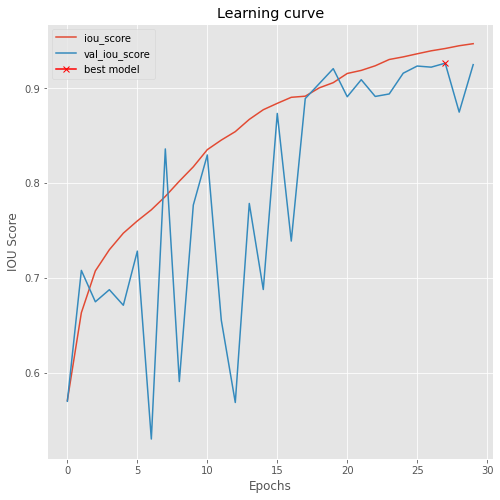

In [26]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(h.history["iou_score"], label="iou_score")
plt.plot(h.history["val_iou_score"], label="val_iou_score")
plt.plot(np.argmax(h.history["val_iou_score"]), np.max(h.history["val_iou_score"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("IOU Score")
plt.legend()

## [5.2] Plotting Loss function

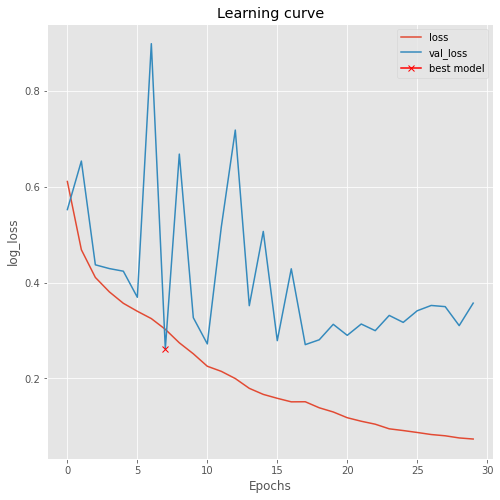

In [27]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(h.history["loss"], label="loss")
plt.plot(h.history["val_loss"], label="val_loss")
plt.plot(np.argmin(h.history["val_loss"]), np.min(h.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

## [6.0] Evaluating Model

In [28]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=2)

5/5 - 1s - loss: 0.3573 - iou_score: 0.9264


[0.35725852847099304, 0.9263790249824524]

In [29]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=2)
preds_val = model.predict(X_valid, verbose=2)

10/10 - 4s
5/5 - 1s


## [6.1] Thresholding Model

In [30]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [31]:
preds_train_threshold = (preds_train > 0.75).astype(np.uint8)
preds_val_threshold = (preds_val > 0.75).astype(np.uint8)

## [7.0] Plotting predicted masks

In [37]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[1].imshow(X[ix, 0])
    ax[0].imshow(X[ix].squeeze(), cmap = 'hot')
    ax[0].set_title('Original Image')
    if has_mask:
        ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask Image')


    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].imshow(preds[ix].squeeze())
    ax[2].set_title('Mask predicted')
    
  #  ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
  #  if has_mask:
  #      ax[3].imshow(binary_preds[ix].squeeze())
  # ax[3].set_title('Mask Predicted binary')

## [7.1] Plotting Train Images with predicted masks

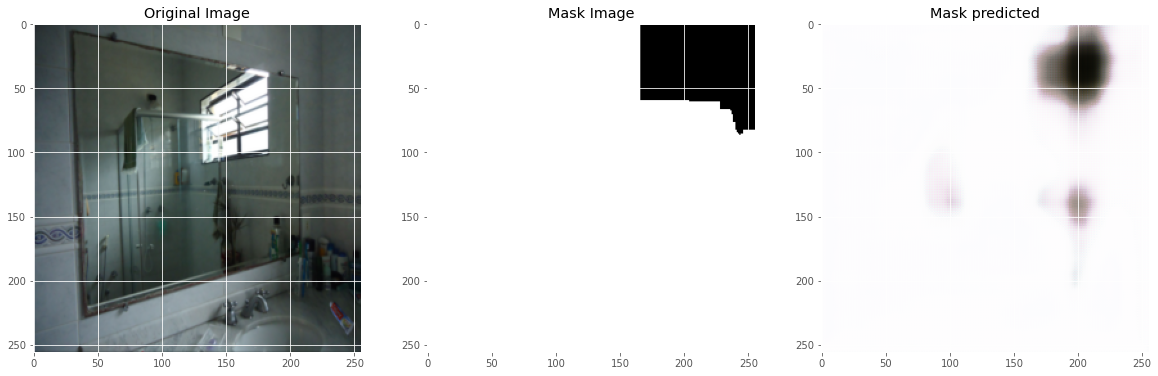

In [38]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix= 10)

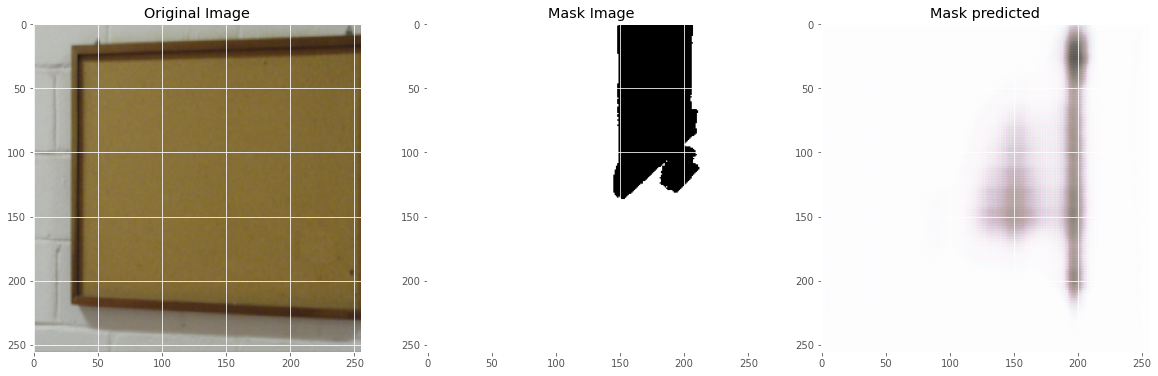

In [39]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix= 120)

- For train images we can see the predicted masks our nearly close and not exactly close

## [7.2] Plotting test images with predicted masks

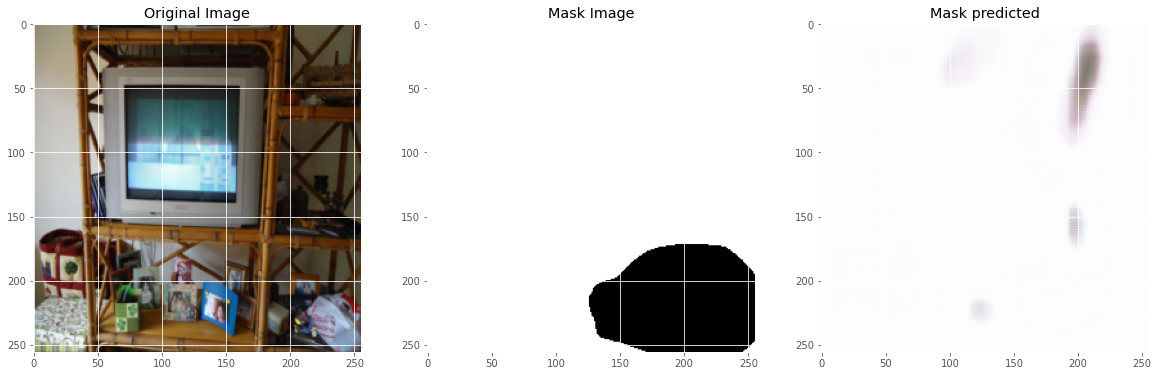

In [40]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix= 112)

- If we check the predicted masks for this image it is a failure case as we know all the images are not getting predicted well.
- There are some boundary case and I think this could have overcome by trying to train our model on a large dataset

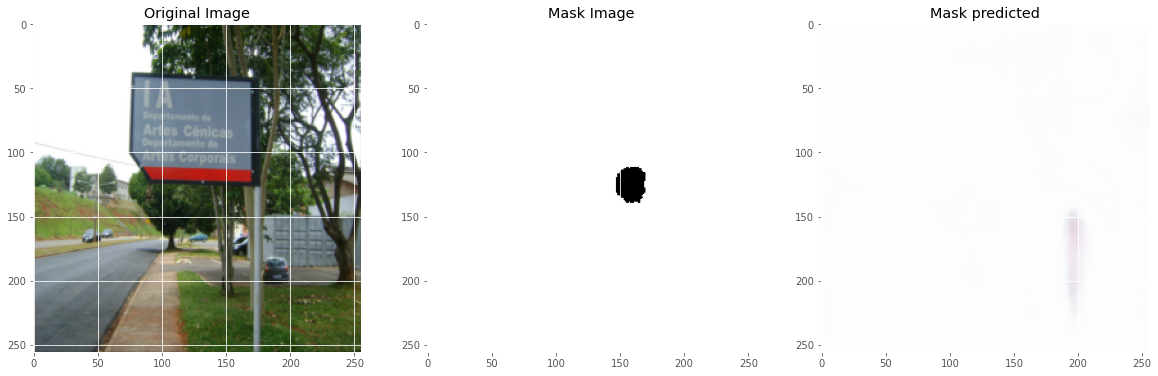

In [46]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix= 77)

- For the above image we have a corresponding mask near the pole and in the predicted mask it returns the mask near pole

- If we check our model is performing still well on unseen data
- This is the reason because we our training our model on very less data if we train our model on large numebr of dataset we could have expected some better results
- This are the results from U-Net++ Model
- I have used colab to train my model because I was facing a lot of issues with my tensorflow version and cudNN version corresponding tf v2.3